In [1]:
import numpy as np
import matplotlib.pyplot as plt

from acm.projects.bgs import *
from acm.observables.combined import BaseCombinedObservable as CombinedObservable

## Emulator tests

In [ ]:
stat = CombinedObservable([
    GalaxyCorrelationFunctionMultipoles(),
    # DensitySplitCorrelationFunctionMultipoles(),
])

covariance_matrix = stat.get_covariance_matrix()
data_error = np.sqrt(np.diag(covariance_matrix))

mock_idx = 96
truth = stat.lhc_y[mock_idx]
pred = stat.get_model_prediction(stat.lhc_x[mock_idx])

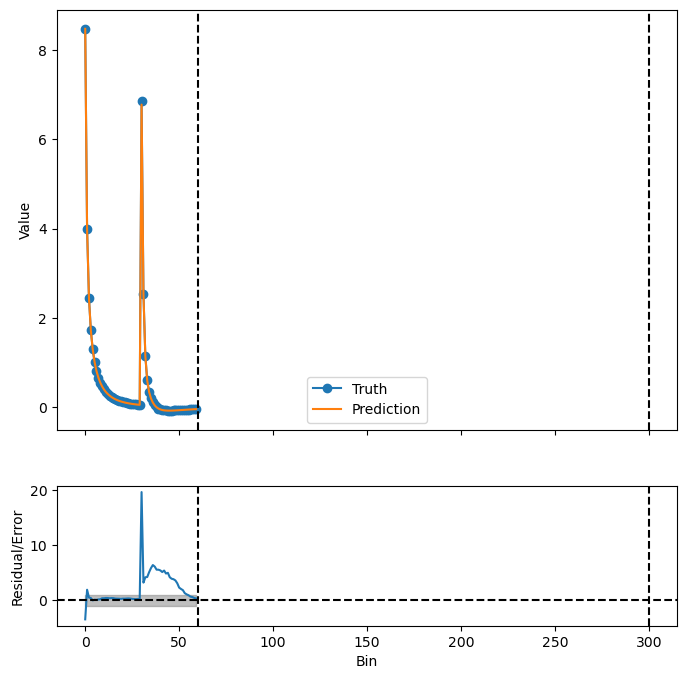

In [ ]:
fix, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8), height_ratios=[3, 1])

ax[0].plot(truth, label='Truth', marker='o')
ax[0].plot(pred, label='Prediction')

ax[1].plot((truth - pred)/data_error)
ax[1].axhline(0, color='k', linestyle='--')
ax[1].fill_between(list(range(len(truth))), -1, 1, color='gray', alpha=0.5)

separations = [len(stat.observables[i].bin_values) for i in range(len(stat.observables))]
for i in range(2):
    ax[0].axvline(separations[i], color='k', linestyle='--')
    ax[1].axvline(separations[i], color='k', linestyle='--')

ax[0].legend()

ax[1].set_xlabel('Bin')
ax[0].set_ylabel('Value')
ax[1].set_ylabel('Residual/Error');

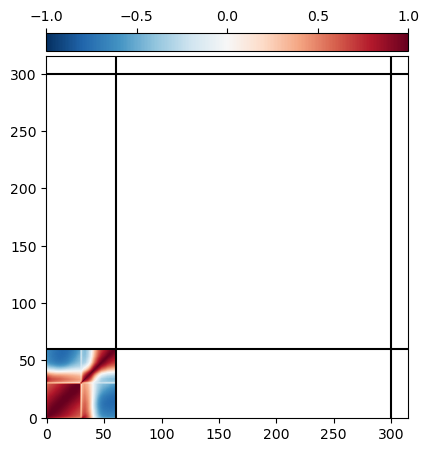

In [4]:
from acm.data.io_tools import correlation_from_covariance
from mpl_toolkits.axes_grid1 import make_axes_locatable

correlation_matrix = correlation_from_covariance(covariance_matrix)
    
fig, ax = plt.subplots(figsize=(5, 5))
cmap = plt.get_cmap('RdBu_r')

im = ax.imshow(correlation_matrix, origin='lower', cmap=cmap, vmin=-1, vmax=1)

for i in separations:
    ax.axvline(i, color='black')
    ax.axhline(i, color='black')

# Create colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)
cb = fig.colorbar(im,cax=cax, orientation="horizontal", fraction=0.046, pad=0.05, ticks=[-1, -0.5, 0, 0.5, 1]) #colorbar on top
cb.ax.xaxis.set_ticks_position('top')